# Palaeovalley_NDVI_linear_regression

This code extracts Landsat red and NIR data and calculates NDVI for a specified case study region. This code handles large data areas by splitting up the queries to the AGDC into 1 month blocks, saving to individual netcdf files, then pulling them all together to create monthly mean NDVI. 

The change in NDVI between two months (e.g. January - June) is calculated be performing a linear regression and recording the slope of the relationship. This indicates whether vegetation is "green-ing" or drying through time. This can provide an indication of a groundwater supply. 

The data array and geotiff are output to /g/data for later use. 

Created by Claire Krause December 2016 Datacube version 2
Based on regression code from Neil Symington

**Code dependencies**
- csv file containing the bounding boxes for the case study site/s
- access to /g/data for writing out interim code

**Accompanying code**

Accompanying code has been written for raijin to allow for multiple study sites to be processed at once. The code spawns a new CPU process for each case study site, which run on raijin in a non-interactive way. The outputs from this code are written into /g/data. These codes can be found at https://github.com/CEKrause/Palaeovalleys_AGDC/tree/master/NDVI:
- Palaeovalley_NDVI_linear_regression_raijin_(JanJun/JulDec).py 
    (Python code similar to that below - just changed to run on raijin)
- Run_NDVI_regression 
    (PBS submission script for raijin. This script creates a single CPU job for each study site in multiples of 16. Run by typing "qsub Run_NDVI_regression" into raijin from /g/data/p25/cek156/NDVI directory)

## Set up the inputs and functions

In [1]:
%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio
import pandas
from scipy import stats
import os
import numpy as np

If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [2]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://cek156@130.56.244.227:6432/datacube)>>>

In [24]:
def geom_query(geom, geom_crs='EPSG:28352'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = zip(*[geom.interpolate(d).coords[0] for d in dist])
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
        }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

def pq_fuser(dest, src):
    valid_bit = 8
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

def return_good_pixels(nbar, pq):
    """
    This function uses pixel quality information to mask out and remove pixel quality artifacts from extracted data.
    """
    mask_components = {'cloud_acca':'no_cloud',
    'cloud_shadow_acca' :'no_cloud_shadow',
    'cloud_shadow_fmask' : 'no_cloud_shadow',
    'cloud_fmask' :'no_cloud',
    'blue_saturated' : False,
    'green_saturated' : False,
    'red_saturated' : False,
    'nir_saturated' : False,
    'swir1_saturated' : False,
    'swir2_saturated' : False,
    'contiguous':True}
    pqmask = masking.make_mask(pq.pixelquality,  **mask_components)
    return nbar.where(pqmask)


def iterate_end_date(start_date):
    """ 
    Using the starting date, this function returns an end date, calculated as two months from the starting date
    """
    # Split the string again so we can create the end date
    Year, Month, Day = start_date.split('-')
    # Now create the string for the end date
    Monthnum = int(Month)
    Monthnum = Monthnum + 2
    # Check whether we've gone into a new year
    if Monthnum == 13:
        Monthnum = 1
        Yearnum = int(Year)
        Yearnum = Yearnum + 1
        Year = str(Yearnum)
    if Monthnum == 14:
        Monthnum = 2
        Yearnum = int(Year)
        Yearnum = Yearnum + 1
        Year = str(Yearnum)
    # Change it back to a string
    Month = str(Monthnum)
    # And zero pad it so that there are two numbers
    Month = Month.zfill(2)
    # Now construct the end date
    end_date = Year + '-' + Month + '-' + Day
    return end_date, Year

def add_ds_info(new_ds, old_ds):
    """ 
    This function explicitly adds the coordinate reference and affine info to a new dataset, based on the info from the
    original dataset.
    """
    new_ds.attrs['affine'] = old_ds.affine
    new_ds.attrs['crs'] = old_ds.crs


#This function applies a linear regression to a grid over a set time interval
def linear_regression_grid(input_array, mask_no_trend = True):
    '''
    This function applies a linear regression to a grid over a set time interval by looping through lat and lon 
    and calculating the linear regression through time for each pixel.
    '''

    ylen = len(input_array.y)
    xlen = len(input_array.x)
    from itertools import product
    coordinates = product(range(ylen), range(xlen))

    slopes = np.zeros((ylen, xlen))
    p_values = np.zeros((ylen, xlen))
    print('Slope shape is ', slopes.shape)

    for y, x in coordinates:
        val = input_array.isel(x = x, y = y)
        val[val<0] = np.nan

        # Check that we have at least three values to perform our linear regression on
        if np.count_nonzero(~np.isnan(val)) > 3:
            slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
        else:
            slopes[y, x] = np.nan
            intercept = np.nan
            r_sq = np.nan
            p_values[y, x] = np.nan

    #Get coordinates from the original xarray
    lat  = input_array.coords['y']
    long = input_array.coords['x']
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_no_trend == True:
        slopes[p_values>0.05]=np.nan        
    # Write arrays into a x-array
    slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
    p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x']) 
    return slope_xr, p_val_xr

def month_cut(data, month_1, month_2):
    
    sliced_xr = list(data.groupby('month'))[monthDict[month_1]:monthDict[month_2] + 1]
    
    #Concatenate all the arrays into one xarray
    split_xr = sliced_xr[0][1]
    
    for i in range(int(monthDict[month_2]) - int(monthDict[month_1])):
        split_xr = xr.concat([split_xr, sliced_xr[i+1][1]], dim = 'month')
                     
    return split_xr

def write_geotiff(filename, dataset, time_index=None, profile_override=None):
    """
    Write an xarray dataset to a geotiff
    :attr bands: ordered list of dataset names
    :attr time_index: time index to write to file
    :attr dataset: xarray dataset containing multiple bands to write to file
    :attr profile_override: option dict, overrides rasterio file creation options.
    """
    profile_override = profile_override or {}

    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes

    profile = DEFAULT_PROFILE.copy()
    profile.update({
        'width': dataset.dims['x'],
        'height': dataset.dims['y'],
        'affine': dataset.affine,
        #'crs': dataset.crs.crs_str,
        'crs': dataset.crs,
        'count': len(dataset.data_vars),
        'dtype': str(dtypes.pop())
    })
    profile.update(profile_override)

    with rasterio.open(filename, 'w', **profile) as dest:
        for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
            #dest.write(data.isel(time=time_index).data, bandnum)
            dest.write(data, bandnum)
            print ('Done')

## Read in the case study bounding box/es

In [4]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('~/palaeovalleys/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

## Set up the AGDC query

In [5]:
# Choose your site for this example
# Here we will select our testing site, so that we can demonstrate the code works without waiting for a full area to run
num = 48
Studysite = names.ix[num]
print(Studysite)

Name      Testing
minlat        -23
maxlat     -22.95
minlon      133.1
maxlon     133.15
Name: 48, dtype: object


In [6]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST


#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     #'green',
                     'red', 
                     'nir',
                     #'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensor8 = 'ls8'
sensor7 = 'ls7'
sensor5 = 'ls5'

query = {'lat': (names.maxlat[num], names.minlat[num]), 
         'lon': (names.minlon[num], names.maxlon[num]),
         'crs': 'EPSG:4326'}
query

{'crs': 'EPSG:4326',
 'lat': (-22.949999999999999, -23.0),
 'lon': (133.09999999999999, 133.15000000000001)}

# Retrieve the NDVI and PQ for the spatiotemporal range of interest

Note that given our data are ~1 deg x ~1 deg, we need to break up our query so that we don't run out of memory on the NCI. We will do this by processing the data one month at a time. Once NDVI is calculated for the month, a netcdf file is written out for that time slice, and the code moves onto the next time step. At the end of this part of the code, we will have one netcdf file for every month from each landsat sensor (8, 7 and 5).

In [23]:
# Set up the bounds for your data extraction
start_date = '1980-01-01'
end_date = '2016-12-31'
OUTPUT_FILENAME = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/NDVI8_month_%s.nc'

In [7]:
#Retrieve the NBAR and PQ data for sensor 8

# Check if directory exists, and if not, make it
dir_check = os.path.isdir('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual')
if dir_check == False:
    os.makedirs('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual')

# And now grab the data...
for time_period in pd.period_range(start_date, end_date, freq='M'):
    query['time'] = (time_period.start_time, time_period.end_time)
    nbar = dc.load(product= sensor8+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    if nbar :    
        pq = dc.load(product= sensor8+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
        crs = nbar.crs.wkt
        affine = nbar.affine
        # Filter the data to remove bad pixels
        nbar = return_good_pixels(nbar, pq)
        pq = None

        # Create monthly averaged data
        monthly_nbar = nbar.resample('M', dim = 'time', how = 'mean')
        ndvi = (monthly_nbar['nir'] - monthly_nbar['red']) / (monthly_nbar['nir'] + monthly_nbar['red'])
        ds = ndvi.to_dataset(name='ndvi')
        ds.attrs['affine'] = affine
        ds.attrs['crs'] = crs

        output_filename = OUTPUT_FILENAME % time_period.start_time.strftime('%Y-%m')
        ds.to_netcdf(path=output_filename, mode='w')

wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-03.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-04.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-05.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-06.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-07.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-08.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-09.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-11.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2013-12.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2014-01.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2014-02.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2014-03.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2014-04.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_201

In [8]:
#Retrieve the NBAR and PQ data for sensor 7

# Check if directory exists, and if not, make it
dir_check = os.path.isdir('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual')
if dir_check == False:
    os.makedirs('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual')

# And now grab the data...
for time_period in pd.period_range(start_date, end_date, freq='M'):
    query['time'] = (time_period.start_time, time_period.end_time)
    nbar = dc.load(product= sensor7+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    if nbar :    
        pq = dc.load(product= sensor7+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
        crs = nbar.crs.wkt
        affine = nbar.affine
        # Filter the data to remove bad pixels
        nbar = return_good_pixels(nbar, pq)
        pq = None

        # Create monthly averaged data
        monthly_nbar = nbar.resample('M', dim = 'time', how = 'mean')
        ndvi = (monthly_nbar['nir'] - monthly_nbar['red']) / (monthly_nbar['nir'] + monthly_nbar['red'])
        ds = ndvi.to_dataset(name='ndvi')
        ds.attrs['affine'] = affine
        ds.attrs['crs'] = crs

        output_filename = OUTPUT_FILENAME % time_period.start_time.strftime('%Y-%m')
        ds.to_netcdf(path=output_filename, mode='w')

wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1999-07.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1999-08.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1999-09.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1999-10.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1999-12.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2000-01.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2000-03.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2000-04.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2000-05.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2000-06.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2000-07.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2000-08.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_2000-09.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_200

In [9]:
#Retrieve the NBAR and PQ data for sensor 5

# Check if directory exists, and if not, make it
dir_check = os.path.isdir('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual')
if dir_check == False:
    os.makedirs('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual')

# And now grab the data...
for time_period in pd.period_range(start_date, end_date, freq='M'):
    query['time'] = (time_period.start_time, time_period.end_time)
    nbar = dc.load(product= sensor5+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    if nbar :    
        pq = dc.load(product= sensor5+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
        crs = nbar.crs.wkt
        affine = nbar.affine
        # Filter the data to remove bad pixels
        nbar = return_good_pixels(nbar, pq)
        pq = None

        # Create monthly averaged data
        monthly_nbar = nbar.resample('M', dim = 'time', how = 'mean')
        ndvi = (monthly_nbar['nir'] - monthly_nbar['red']) / (monthly_nbar['nir'] + monthly_nbar['red'])
        ds = ndvi.to_dataset(name='ndvi')
        ds.attrs['affine'] = affine
        ds.attrs['crs'] = crs

        output_filename = OUTPUT_FILENAME % time_period.start_time.strftime('%Y-%m')
        ds.to_netcdf(path=output_filename, mode='w')

wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1986-08.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1987-05.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1987-09.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1987-10.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1987-11.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1987-12.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1988-01.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1988-02.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1988-03.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1988-04.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1988-05.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1988-06.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_1988-07.nc
wrote /g/data/p25/cek156/NDVI/Testing/individual/NDVI8_month_198

## Combine the individual month netcdf files into averages for all months

In [10]:
jans = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*01.nc', concat_dim='time')
jan = jans.mean(dim = 'time')
febs = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*02.nc', concat_dim='time')
feb = febs.mean(dim = 'time')
mars = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*03.nc', concat_dim='time')
mar = mars.mean(dim = 'time')
aprs = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*04.nc', concat_dim='time')
apr = aprs.mean(dim = 'time')
mays = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*05.nc', concat_dim='time')
may = mays.mean(dim = 'time')
juns = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*06.nc', concat_dim='time')
jun = juns.mean(dim = 'time')
juls = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*07.nc', concat_dim='time')
jul = juls.mean(dim = 'time')
augs = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*08.nc', concat_dim='time')
aug = augs.mean(dim = 'time')
seps = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*09.nc', concat_dim='time')
sep = seps.mean(dim = 'time')
octs = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*10.nc', concat_dim='time')
octs = octs.mean(dim = 'time')
novs = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*11.nc', concat_dim='time')
nov = novs.mean(dim = 'time')
decs = xr.open_mfdataset('/g/data/p25/cek156/NDVI/' + Studysite.Name + '/individual/*12.nc', concat_dim='time')
dec = decs.mean(dim = 'time')

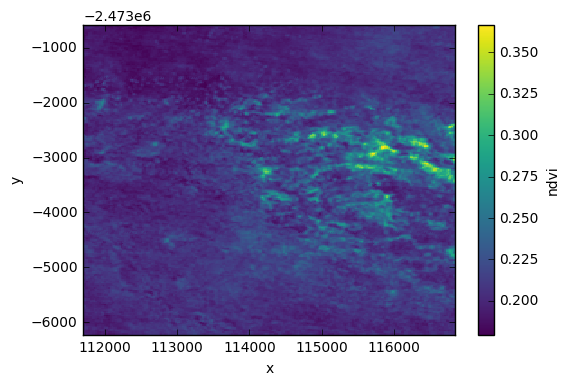

In [11]:
# Plot just one month to see what the data looks like
octs.ndvi.plot()

## Concatenate the data into a single array and save

In [12]:
#Concatenate and sort the different sensor xarrays into a single xarray
ndvi_monthly = xr.concat([jan['ndvi'], feb['ndvi'], mar['ndvi'], apr['ndvi'], may['ndvi'], jun['ndvi'],
                         jul['ndvi'], aug['ndvi'], sep['ndvi'], octs['ndvi'], nov['ndvi'], dec['ndvi']], 'month')
print(ndvi_monthly)

<xarray.DataArray 'ndvi' (month: 12, y: 226, x: 206)>
dask.array<concate..., shape=(12, 226, 206), dtype=float64, chunksize=(1, 226, 206)>
Coordinates:
  * y        (y) float64 -2.474e+06 -2.474e+06 -2.474e+06 -2.474e+06 ...
  * x        (x) float64 1.117e+05 1.117e+05 1.118e+05 1.118e+05 1.118e+05 ...
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11


In [13]:
# Save the outputs so that we don't need to keep running this script
ds = ndvi_monthly.to_dataset(name='ndvi')
ds.attrs['affine'] = affine
ds.attrs['crs'] = crs
output_filename = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/NDVI_monthly_concat.nc'
ds.to_netcdf(path = output_filename, mode = 'w')
print('wrote %s' % output_filename)

wrote /g/data/p25/cek156/NDVI/Testing/NDVI_monthly_concat.nc


# Perform the linear regression

Choose the range of months you would like to perform the regression over. E.g. February to October covers the end of the wet eason into the dry season in northern Australia.

In [16]:
#Define time interval and months range
month_1 = 'February'
#f you want to only look at one month then simply make month_1 equal to month_2
month_2 = 'October'

In [17]:
#Define a dictionary for months
monthDict={'January':0, 'February':1, 'March':2, 'April':3, 'May':4, 'June':5, 'July':6, 'August':7, 'September':8,
           'October':9, 'November':10, 'December':11}

#Split pull out all of the months of interest using the function defined above
split_data = month_cut(ndvi_monthly, month_1, month_2)

#Now perform the linear regression
slope_xr, p_val_xr = linear_regression_grid(split_data, mask_no_trend = True)

# Save the outputs so that we don't need to keep running this script
ds = slope_xr.to_dataset(name='slope')
ds.attrs['affine'] = affine
ds.attrs['crs'] = crs
output_filename = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/NDVI_slope.nc'
ds.to_netcdf(path = output_filename, mode = 'w')
print('wrote %s' % output_filename)

ds = p_val_xr.to_dataset(name='p_val')
ds.attrs['affine'] = affine
ds.attrs['crs'] = crs
output_filename = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/NDVI_pVal.nc'
ds.to_netcdf(path = output_filename, mode = 'w')
print('wrote %s' % output_filename)

arr shape is  (9, 226, 206)
slopes and p_values empty arrays created
wrote /g/data/p25/cek156/NDVI/Testing/NDVI_slope.nc
wrote /g/data/p25/cek156/NDVI/Testing/NDVI_pVal.nc


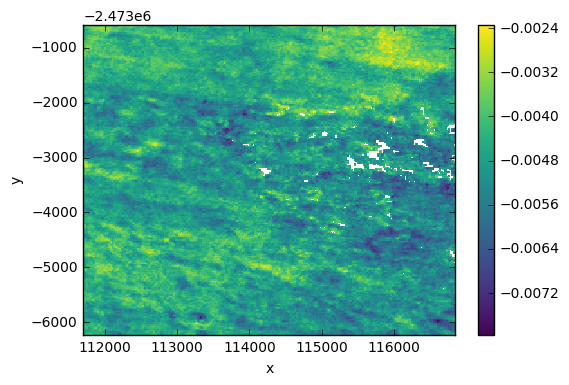

In [18]:
# Plot the slope (i.e. rate of change) across the chosen months
slope_xr.plot()

This plot indicates the rate of change of NDVI between the two selected months, based on average data for each month. Monthly averages are derived from Landsat 5, 7 and 8, for the time period chosen above. 

More negative values indicate a faster rate of change from greener to less green. More positive negative values suggest a slower rate, and a possible groundwater source?

# Save outputs

In [25]:
#Write the files out into a tif file for viewing in GIS

# You may need to adjust the default_profile values so that blockysize is not larger than the xr spatial dimensions
print(ds)

outfile = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/NDVI_drying_trend.tiff'

#Function below is from https://github.com/data-cube/agdc-v2/blob/develop/datacube/helpers.py

DEFAULT_PROFILE = {
    'blockxsize': 128,
    'blockysize': 128,
    'compress': 'lzw',
    'driver': 'GTiff',
    'interleave': 'band',
    'nodata': 0.0,
    'photometric': 'RGBA',
    'tiled': True}

write_geotiff(outfile, slope_xr)

<xarray.Dataset>
Dimensions:  (x: 206, y: 226)
Coordinates:
  * y        (y) float64 -2.474e+06 -2.474e+06 -2.474e+06 -2.474e+06 ...
  * x        (x) float64 1.117e+05 1.117e+05 1.118e+05 1.118e+05 1.118e+05 ...
Data variables:
    p_val    (y, x) float64 -0.004202 -0.003793 -0.004079 -0.003684 ...
Attributes:
    affine: | 25.00, 0.00, 111700.00|
| 0.00,-25.00,-2473575.00|
| 0.00, 0.00, 1.00|
    crs: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER...


/g/data/v10/public/modules/agdc-py3-env/20161201/envs/agdc/lib/python3.5/site-packages/ipykernel/__main__.py:216: DeprecationWarning: The 'affine' kwarg in rasterio.open() is deprecated at 1.0 and only remains to ease the transition.  Please switch to the 'transform' kwarg.  See https://github.com/mapbox/rasterio/issues/86 for details.


Done
